# Week 2: Preprocessing Pipeline Integration

This notebook demonstrates a basic image preprocessing pipeline, including:
1. Loading an image.
2. Downsampling (and optionally upsampling).
3. Conversion to a suitable color space (HSV or L\*a\*b\*).
4. Histogram equalization of the luminance channel.
5. Visualization of intermediate steps and calculation of simple contrast metrics.

In [2]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

## 1. Configuration and Helper Functions

In [5]:
# --- Configuration ---
INPUT_IMAGE_PATH = 'esp32_test_image.png' # Or your 'test_image_detail.jpg'
OUTPUT_DIR_NOTEBOOK = 'output_week2_saturday_notebook' # Separate output for notebook
os.makedirs(OUTPUT_DIR_NOTEBOOK, exist_ok=True)

DOWNSAMPLE_FACTOR = 2
UPSAMPLE_FACTOR_AFTER_DOWN = 1 # 1 means process downsampled, DOWNSAMPLE_FACTOR means restore size
LUMINANCE_EQ_COLOR_SPACE = 'LAB' # 'HSV' or 'LAB'

# --- Matplotlib Display Helper ---
def display_img(img_bgr, title="Image", cmap=None, save_path=None):
    plt.figure(figsize=(6,6))
    if img_bgr.ndim == 2 or cmap: # Grayscale
        plt.imshow(img_bgr, cmap=cmap if cmap else 'gray')
    else: # Color
        plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    if save_path:
        # Ensure BGR for saving if it was converted for display
        if img_bgr.ndim == 3 and cmap is None: # color image
             cv2.imwrite(save_path, img_bgr)
        elif img_bgr.ndim == 2: # grayscale
             cv2.imwrite(save_path, img_bgr)
        print(f"Saved: {save_path}")
    plt.show()

def display_comparison(img1_bgr, img2_bgr, title1="Before", title2="After", main_title="", save_path_base=None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(main_title, fontsize=14)

    # Image 1
    if img1_bgr.ndim == 2:
        axs[0].imshow(img1_bgr, cmap='gray')
    else:
        axs[0].imshow(cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2RGB))
    axs[0].set_title(title1)
    axs[0].axis('off')
    if save_path_base and img1_bgr is not None:
        cv2.imwrite(f"{save_path_base}_1.png", img1_bgr)

    # Image 2
    if img2_bgr.ndim == 2:
        axs[1].imshow(img2_bgr, cmap='gray')
    else:
        axs[1].imshow(cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2RGB))
    axs[1].set_title(title2)
    axs[1].axis('off')
    if save_path_base and img2_bgr is not None:
        cv2.imwrite(f"{save_path_base}_2.png", img2_bgr)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    if save_path_base: print(f"Comparison images saved with base: {save_path_base}")


# --- Image Processing Functions (from script, adapted) ---
def downsample_image_nb(image, factor):
    if factor <= 1: return image
    return cv2.resize(image, (int(image.shape[1]/factor), int(image.shape[0]/factor)), interpolation=cv2.INTER_AREA)

def upsample_image_nb(image, factor, method=cv2.INTER_LINEAR):
    if factor <= 1: return image
    return cv2.resize(image, (int(image.shape[1]*factor), int(image.shape[0]*factor)), interpolation=method)

def equalize_luminance_channel_nb(image_bgr, color_space_choice='LAB'):
    processed_image_bgr = image_bgr.copy()
    luminance_original = None
    luminance_equalized = None

    if color_space_choice == 'HSV':
        img_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(img_hsv)
        luminance_original = v.copy()
        v_eq = cv2.equalizeHist(v)
        luminance_equalized = v_eq.copy()
        img_hsv_eq = cv2.merge([h, s, v_eq])
        processed_image_bgr = cv2.cvtColor(img_hsv_eq, cv2.COLOR_HSV2BGR)
    elif color_space_choice == 'LAB':
        img_lab = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2Lab)
        l, a, b = cv2.split(img_lab)
        luminance_original = l.copy()
        l_eq = cv2.equalizeHist(l)
        luminance_equalized = l_eq.copy()
        img_lab_eq = cv2.merge([l_eq, a, b])
        processed_image_bgr = cv2.cvtColor(img_lab_eq, cv2.COLOR_Lab2BGR)
    else:
        print(f"Error: Unsupported color space '{color_space_choice}'")
        return image_bgr, None, None

    return processed_image_bgr, luminance_original, luminance_equalized

# --- Contrast Metric ---
def calculate_rms_contrast(gray_image):
    """Calculates RMS contrast of a grayscale image."""
    # Ensure float for calculation
    gray_image_float = gray_image.astype(np.float32) / 255.0 
    # Mean intensity
    mean_intensity = np.mean(gray_image_float)
    # Standard deviation of intensities (RMS contrast)
    rms_contrast = np.sqrt(np.mean((gray_image_float - mean_intensity)**2))
    return rms_contrast

print("Configuration and helper functions defined.")

Configuration and helper functions defined.


## 2. Load Original Image

Saved: output_week2_saturday_notebook/00_original.png


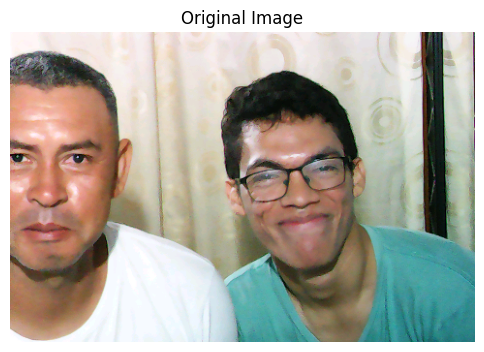

Original Image RMS Contrast: 0.2481


In [6]:
img_original_bgr = cv2.imread(INPUT_IMAGE_PATH)
if img_original_bgr is None:
    raise FileNotFoundError(f"Could not load image: {INPUT_IMAGE_PATH}")

current_img_bgr = img_original_bgr.copy()
display_img(current_img_bgr, "Original Image", 
            save_path=os.path.join(OUTPUT_DIR_NOTEBOOK, "00_original.png"))

# Calculate initial contrast (on grayscale version)
gray_original = cv2.cvtColor(current_img_bgr, cv2.COLOR_BGR2GRAY)
contrast_original = calculate_rms_contrast(gray_original)
print(f"Original Image RMS Contrast: {contrast_original:.4f}")

## 3. Downsampling (and Optional Upsampling)

Saved: output_week2_saturday_notebook/01_downsampled_x2.png


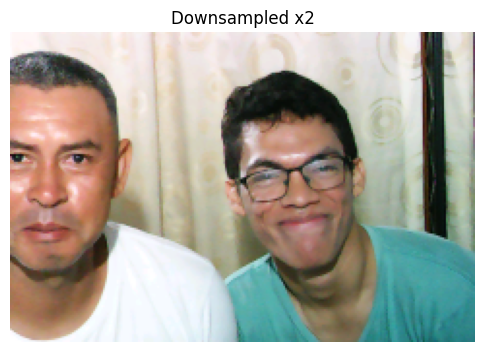

Upsampling skipped.
Saved: output_week2_saturday_notebook/03_pre_equalization.png


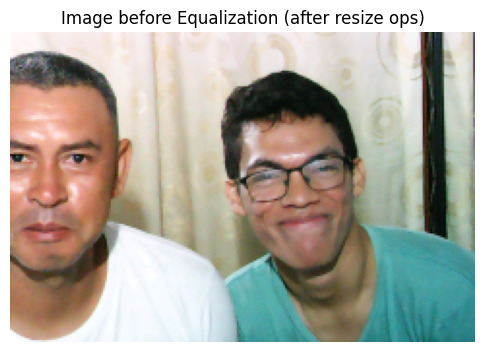

Pre-Equalization Image RMS Contrast: 0.2463


In [7]:
img_after_resize_bgr = current_img_bgr.copy() # Start with current image

if DOWNSAMPLE_FACTOR > 1:
    img_downsampled_bgr = downsample_image_nb(current_img_bgr, DOWNSAMPLE_FACTOR)
    display_img(img_downsampled_bgr, f"Downsampled x{DOWNSAMPLE_FACTOR}",
                save_path=os.path.join(OUTPUT_DIR_NOTEBOOK, f"01_downsampled_x{DOWNSAMPLE_FACTOR}.png"))
    img_after_resize_bgr = img_downsampled_bgr
else:
    print("Downsampling skipped.")

if UPSAMPLE_FACTOR_AFTER_DOWN > 1:
    # If DOWNSAMPLE_FACTOR was > 1 and UPSAMPLE_FACTOR_AFTER_DOWN = DOWNSAMPLE_FACTOR,
    # this attempts to restore original size for processing.
    # Otherwise, it upsamples the (potentially already downsampled) image.
    img_upsampled_bgr = upsample_image_nb(img_after_resize_bgr, UPSAMPLE_FACTOR_AFTER_DOWN, method=cv2.INTER_CUBIC)
    display_img(img_upsampled_bgr, f"Upsampled x{UPSAMPLE_FACTOR_AFTER_DOWN} (from previous step)",
                save_path=os.path.join(OUTPUT_DIR_NOTEBOOK, f"02_upsampled_x{UPSAMPLE_FACTOR_AFTER_DOWN}.png"))
    img_after_resize_bgr = img_upsampled_bgr
else:
    print("Upsampling skipped.")

current_img_bgr = img_after_resize_bgr # This is the image that will be equalized
display_img(current_img_bgr, "Image before Equalization (after resize ops)",
            save_path=os.path.join(OUTPUT_DIR_NOTEBOOK, "03_pre_equalization.png"))

# Contrast of the image entering equalization stage
gray_pre_eq = cv2.cvtColor(current_img_bgr, cv2.COLOR_BGR2GRAY)
contrast_pre_eq = calculate_rms_contrast(gray_pre_eq)
print(f"Pre-Equalization Image RMS Contrast: {contrast_pre_eq:.4f}")

## 4. Luminance Channel Equalization

We will convert the image to the chosen color space (`LUMINANCE_EQ_COLOR_SPACE`), equalize the luminance channel, and then convert back to BGR.

Performing Luminance Equalization using LAB space...


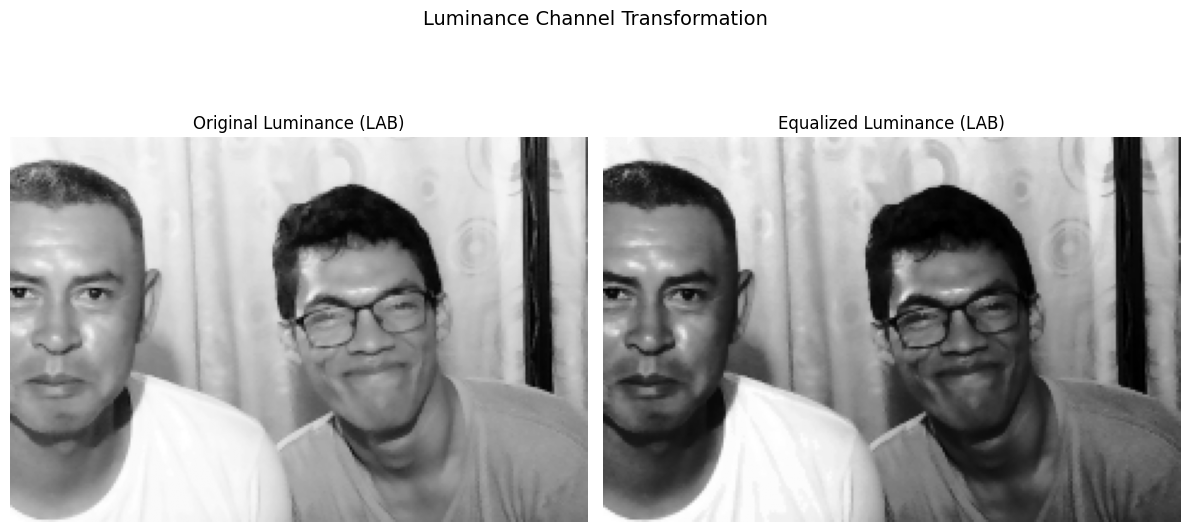

Comparison images saved with base: output_week2_saturday_notebook/04_luminance_LAB


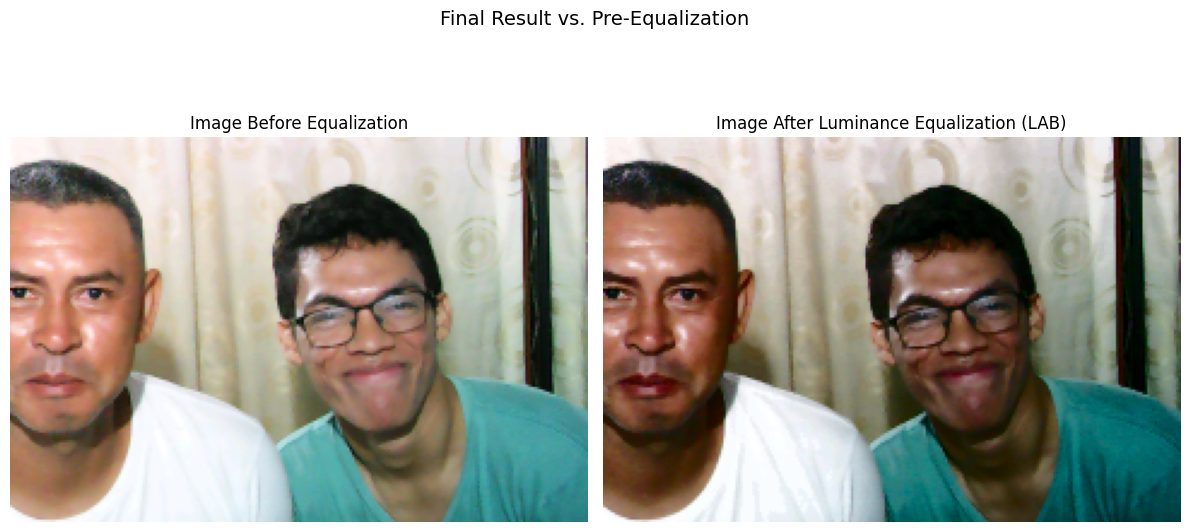

Comparison images saved with base: output_week2_saturday_notebook/05_final_comparison


In [8]:
print(f"Performing Luminance Equalization using {LUMINANCE_EQ_COLOR_SPACE} space...")
img_equalized_bgr, lum_original, lum_equalized = equalize_luminance_channel_nb(current_img_bgr, LUMINANCE_EQ_COLOR_SPACE)

if lum_original is not None and lum_equalized is not None:
    display_comparison(lum_original, lum_equalized, 
                       f"Original Luminance ({LUMINANCE_EQ_COLOR_SPACE})", 
                       f"Equalized Luminance ({LUMINANCE_EQ_COLOR_SPACE})",
                       main_title="Luminance Channel Transformation",
                       save_path_base=os.path.join(OUTPUT_DIR_NOTEBOOK, f"04_luminance_{LUMINANCE_EQ_COLOR_SPACE}"))
else:
    print("Could not extract/equalize luminance channels for display.")

display_comparison(current_img_bgr, img_equalized_bgr,
                   "Image Before Equalization",
                   f"Image After Luminance Equalization ({LUMINANCE_EQ_COLOR_SPACE})",
                   main_title="Final Result vs. Pre-Equalization",
                   save_path_base=os.path.join(OUTPUT_DIR_NOTEBOOK, "05_final_comparison"))

current_img_bgr = img_equalized_bgr # Update current image

## 5. Quantitative Contrast Metrics

Let's compare the RMS contrast before and after the luminance equalization.

In [10]:
gray_after_eq = cv2.cvtColor(current_img_bgr, cv2.COLOR_BGR2GRAY)
contrast_after_eq = calculate_rms_contrast(gray_after_eq)

print(f"--- Contrast Summary ---")
print(f"Original Full Image RMS Contrast:         {contrast_original:.4f}")
if DOWNSAMPLE_FACTOR > 1 or UPSAMPLE_FACTOR_AFTER_DOWN > 1:
    print(f"Image before Equalization RMS Contrast: {contrast_pre_eq:.4f}")
print(f"Image after Equalization RMS Contrast:  {contrast_after_eq:.4f}")

if contrast_after_eq > contrast_pre_eq:
    print("Contrast has increased after equalization.")
elif contrast_after_eq < contrast_pre_eq:
    print("Contrast has decreased after equalization (this can happen, e.g. if original was already high contrast).")
else:
    print("Contrast remained the same.")

--- Contrast Summary ---
Original Full Image RMS Contrast:         0.2481
Image before Equalization RMS Contrast: 0.2463
Image after Equalization RMS Contrast:  0.2891
Contrast has increased after equalization.


## 6. Conclusion

This notebook demonstrated a sequential preprocessing pipeline:
- Image loading
- Resizing operations (downsampling and/or upsampling)
- Color space conversion for targeted luminance adjustment
- Histogram equalization on the luminance channel
- Visualization of intermediate and final results
- Basic quantitative assessment of contrast change.

The output images are saved in the `output_week2_saturday_notebook` directory. This pipeline forms a basis for further image processing tasks.
